In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Load libraries

import pandas as pd
import numpy as np
import math
import nltk
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import KFold, train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor

nltk.download('punkt')

sns.set_style('darkgrid')
sns.set_color_codes(palette='dark')
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [4]:
cd gdrive/MyDrive/TER/

/content/gdrive/MyDrive/TER


In [4]:
# load the tsv file into a dataframe
df = pd.read_csv("data/triplets_ende_mt_scored.tsv", names=["source", 'target', 'reference', "TER"] ,sep=".\t", encoding="utf8",engine='python')

In [5]:
# checking duplicated samples
df[df.duplicated() == True]

,source,target,reference,TER


We don't have any!

In [6]:
df.head()

,source,target,reference,TER
0,José Ortega y Gasset visited Husserl at Freiburg in 1934,1934 besuchte José Ortega y Gasset Husserl in Freiburg,José Ortega y Gasset besuchte Husserl in Freiburg im Jahr 1934,0.33
1,"however , a disappointing ninth in China meant that he dropped back to sixth in the standings","eine enttäuschende Neunte in China bedeutete jedoch , dass er in der Gesamtwertung auf den sechsten Platz zurückfiel","ein enttäuschender neunter Platz in China bedeutete jedoch , dass er in der Gesamtwertung auf den sechsten Platz zurückfiel",0.20
2,"in his diary , Chase wrote that the release of Mason and Slidell "" … was like gall and wormwood to me","in seinem Tagebuch , Chase schrieb , dass die Veröffentlichung von Mason und Slidell "" war wie Galle und Wermut für mich","in seinem Tagebuch schrieb Chase , dass die Freilassung von Mason and Slidell „ ... wie Galle und Wermut für mich war",0.30
3,Heavy arquebuses mounted on wagons were called arquebus à croc,schwere Arquebuses auf Waggons montiert wurden Arquebus à croc genannt,"schwere Arquebusen , die auf Wagen montiert waren , wurden „ Arquebus à croc "" genannt",0.47
4,"once North Pacific salmon die off after spawning , usually local bald eagles eat salmon carcasses almost exclusively","sobald der nordpazifische Lachs nach dem Laichen abstirbt , fressen in der Regel lokale Glatzadler fast ausschließlich Lachskörper","sobald der nordpazifische Lachs nach dem Laichen abgestorben ist , fressen die örtlichen Weißkopfseeadler fast ausschließlich Lachsschlachtkörper",0.44


# Part 1 

 Why the choice of splitting on space without using strip() rathar than using it or using nltk word_tokenizer:

 Consider this example with simple edits that are easily spotted:

In [7]:
example = df.iloc[1]
example

source       however , a disappointing ninth in China meant that he dropped back to sixth in the standings                               
target       eine enttäuschende Neunte in China bedeutete jedoch , dass er in der Gesamtwertung auf den sechsten Platz zurückfiel        
reference    ein enttäuschender neunter Platz in China bedeutete jedoch , dass er in der Gesamtwertung auf den sechsten Platz zurückfiel 
TER          0.2                                                                                                                         
Name: 1, dtype: object

In [8]:
print("Actual length: ",len(word_tokenize(example.reference)))
print("Used length:",len(example.reference.split(" ")))

Actual length:  19
Used length: 20


Comparing the target and reference sentence, we can see that there is 4 edits performed on the target sentence to match the reference one (3 alters and 1 addition). And, according to the definition, TER is the minimum number of edits normalized by the length of the reference sentence. The actual length of the reference sentence is 19 yet the results of 4/19 is not equal to the given TER score, but taking the length of the reference with just splitting results in 20 due to the presence of extra space at the end of the sentence and by that 4/20 is equal to the given TER. So, we carried on with normal string spliting. 
This is the case for all the sentences in the dataset, probably due to previous pre-processing done on the sentences. And it seems that the number of edits were normalized by the length of the sentences as they are present in the dataset.

## Compute the length of the source sentence at the word level


In [9]:
def word_length(sen):
    return len(sen.split(" "))

df_length = pd.DataFrame()
df_length['word_length'] = df["source"].map(word_length)    
df_length["TER"] = df["TER"]

In [10]:
df_length.head(5)

,word_length,TER
0,11,0.33
1,18,0.20
2,23,0.30
3,11,0.47
4,19,0.44


## Plot the distribution plot of source sentences length

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


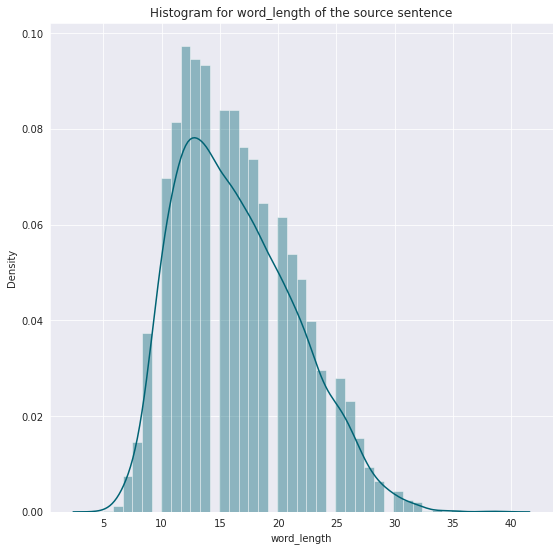

In [11]:
f, ax = plt.subplots(figsize=(9, 9))
sns.distplot(df_length['word_length'], color="c", axlabel='word_length')
ax.set(title="Histogram for word_length of the source sentence")
plt.show()

## Plot the distribution plot of TER

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


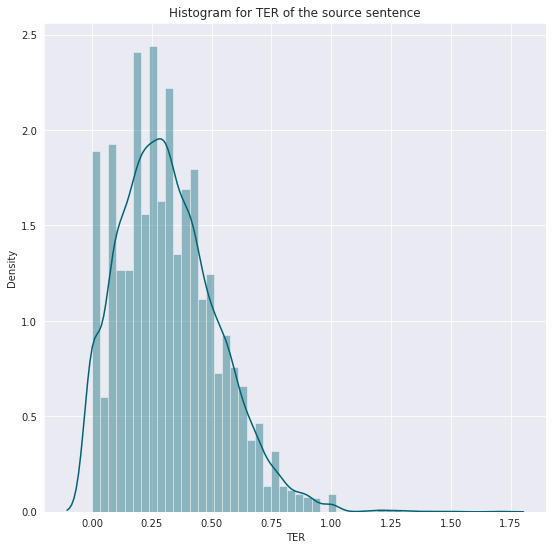

In [12]:
f, ax = plt.subplots(figsize=(9, 9))
sns.distplot(df_length['TER'], color="c", axlabel='TER')
ax.set(title="Histogram for TER of the source sentence")
plt.show()

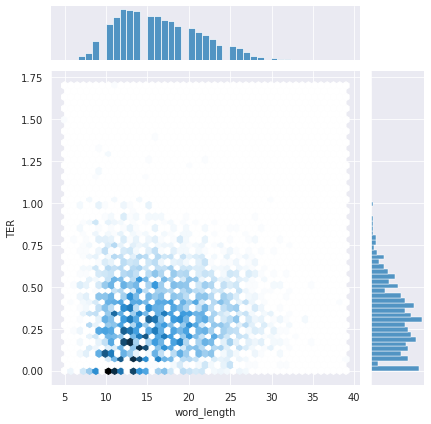

In [13]:
sns.jointplot(data=df_length, x="word_length", y="TER", kind="hex")

In [14]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(df_length['word_length'].values.reshape(-1, 1), df_length['TER'].values.reshape(-1, 1))
m, b = np.polyfit(df_length['word_length'], df_length['TER'], 1)

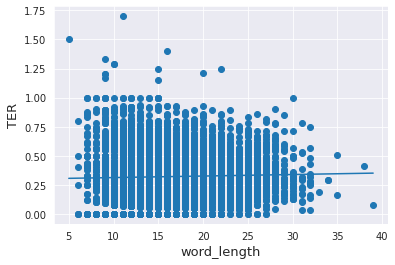

In [15]:
fig, ax = plt.subplots()
ax.plot(range(5,40), m*range(5,40) + b)
ax.scatter(x = df_length['word_length'], y = df_length['TER'])
plt.ylabel('TER', fontsize=13)
plt.xlabel('word_length', fontsize=13)
plt.show()

## Comments
We can clearly see that there is no correlation between the length of the source sentence and the TER.

Its difficult for any linear model to fit and generalize this problem. Even after some test done on several transformation(log, powerTransformation, etc), the same problem remaind. This feature alone will not be enough.

## Predicting TER from the sentence length alone.

### Make train-validation and test data sets.

In [16]:
X = df_length[["word_length"]].values.astype(np.float32)
y = df_length["TER"].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

### Define BaseLine models.


In [17]:
def get_baseline_models():
  """Method that returns a list and names of regression models of interest"""
  basedModels = [
            SVR(),
            XGBRegressor(random_state=random_state, verbosity=0),
            AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state)),
            GradientBoostingRegressor(random_state=random_state),
            DecisionTreeRegressor(random_state=random_state),
            RandomForestRegressor(random_state=random_state),
            ExtraTreesRegressor(random_state=random_state),
            KNeighborsRegressor(),
            Ridge(random_state=random_state),
            Lasso(),
            ]

  model_names = []
  for model in basedModels:
    model_names.append(type(model).__name__)

  return basedModels, model_names

random_state=2


def evaluate_models(X, y, models, Kfold=5):
  """Method that cross validate a list of models and returns their mean rmse and mae scores"""

  results = []
  for model in models:
    cv_result = cross_validate(model, X, y, cv=Kfold, return_estimator=False, 
                               scoring={"mse": make_scorer(mean_squared_error, greater_is_better=False), 
                                        "mae": make_scorer(mean_absolute_error, greater_is_better=False)})
    
    rmse_score = np.sqrt((-1) * cv_result["test_mse"].mean())
    mae_score = - cv_result["test_mae"].mean()
    results.append([rmse_score, mae_score])
  return results
        

In [18]:
models , model_names = get_baseline_models()
scores = evaluate_models(X_train, y_train, models)

type_col = ['baseline_models']
cols = pd.MultiIndex.from_product([type_col, ['RMSE', 'MAE']])
evaluation = pd.DataFrame(scores, columns=cols, index=model_names)

print("Following are the cross validated scores: ")
evaluation

Following are the cross validated scores: 


baseline_models          
                                     RMSE       MAE
SVR                        0.205468        0.161887
XGBRegressor               0.204845        0.162927
AdaBoostRegressor          0.211042        0.170504
GradientBoostingRegressor  0.204913        0.162970
DecisionTreeRegressor      0.205059        0.163064
RandomForestRegressor      0.205031        0.162997
ExtraTreesRegressor        0.205037        0.163045
KNeighborsRegressor        0.225222        0.178873
Ridge                      0.204745        0.162920
Lasso                      0.204756        0.162939

Ridge model has the smallest RMSE and SVR has the smallest MAE.

### Feature Engineering - data preprocessing

Tree based models does not depend on scaling, while Non-tree based models depend hugely on it.

We will try some preprocessing and see how the model prediction will change by scalling.


In [19]:
model_names

['SVR',
 'XGBRegressor',
 'AdaBoostRegressor',
 'GradientBoostingRegressor',
 'DecisionTreeRegressor',
 'RandomForestRegressor',
 'ExtraTreesRegressor',
 'KNeighborsRegressor',
 'Ridge',
 'Lasso']

In [20]:
def get_scaled_models(models, scaler_name, for_='f'):
    """
    Method that takes a list of models and scaler name and whether to apply it on features or target output.
    It returns a list that containes a pipeline of the scaler name entered and a model.

    param models: list of models.
    param scaler_name: either 'yeo-johnson', 'box-cox', "quantile", 'minmax', 'maxabs', 'standard'.
    for_: 'f' for features, 't' for target.
    """
    if scaler_name == 'yeo-johnson':
      scaler = PowerTransformer(method=scaler_name)
    elif scaler_name == 'box-cox':
      scaler = PowerTransformer(method=scaler_name)
    elif scaler_name == "quantile":
      scaler_name = "quantile"
      scaler = QuantileTransformer(output_distribution='normal')
    elif scaler_name == 'minmax':
      scaler = MinMaxScaler()
    elif scaler_name == 'maxabs':
      scaler = MaxAbsScaler()
    elif scaler_name == 'standard':
      scaler = StandardScaler()

    pipelines = []
    for model in models:
      model_name = type(model).__name__
      if for_ == 'f':
        pipelines.append(Pipeline([('scaler', scaler), (model_name, model)]))
      elif for_ == 't':
        pipelines.append(TransformedTargetRegressor(regressor=model, transformer=scaler))
    return pipelines

Lets compare the baseline models with using scalers and transformation of features and the target values

In [ ]:
scalers = ['standard', 'maxabs', 'minmax',  'quantile', 'box-cox', 'yeo-johnson']

evaluations = [evaluation]
for for_ in ['f', 't']:
  for scaler in scalers:
    pipelines = get_scaled_models(models, scaler, for_)
    if scaler == 'box-cox':
      scores = evaluate_models(X_train, y_train+ 10e-10, pipelines)
    else:
      scores = evaluate_models(X_train, y_train, pipelines)
    type_col = [for_+'_'+scaler]
    cols = pd.MultiIndex.from_product([type_col, ['RMSE', 'MAE']])
    new_evaluation = pd.DataFrame(scores, columns=cols, index=model_names)
    evaluations.append(new_evaluation)

comparison = pd.concat(evaluations, axis=1)

In [22]:
comparison

baseline_models            ... t_yeo-johnson          
                                     RMSE       MAE  ...          RMSE       MAE
SVR                        0.205468        0.161887  ...  0.205791      0.161823
XGBRegressor               0.204845        0.162927  ...  0.206496      0.162039
AdaBoostRegressor          0.211042        0.170504  ...  0.206018      0.162295
GradientBoostingRegressor  0.204913        0.162970  ...  0.206569      0.162098
DecisionTreeRegressor      0.205059        0.163064  ...  0.206674      0.162161
RandomForestRegressor      0.205031        0.162997  ...  0.206680      0.162113
ExtraTreesRegressor        0.205037        0.163045  ...  0.206657      0.162147
KNeighborsRegressor        0.225222        0.178873  ...  0.224273      0.176622
Ridge                      0.204745        0.162920  ...  0.206383      0.161980
Lasso                      0.204756        0.162939  ...  0.206330      0.162048

[10 rows x 26 columns]

In [26]:
pkl.dump(comparison, open("comparison1.pkl", "wb"))

The applied scalers on source sentence length and TER almost have no effect on the models and the prediction results did not improve.

### Now  lets tune the SVR and Ridge models

Best cross validated rmse score: 0.20474466734009666
Best Hyperparameters: {'alpha': 1.2000000000000002}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78649a88d0>,
      dtype=object)

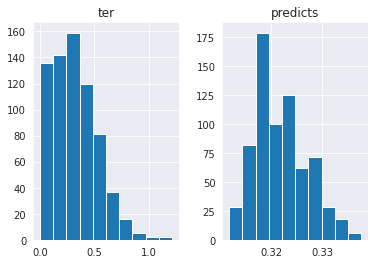

In [28]:
Ridge_model = Ridge()
Ridge_params = {'alpha': np.arange(0.1, 1.5, 0.1) # Regularization strength
               }
# execute search to get estimators
fitted_model = RandomizedSearchCV(Ridge_model,
                                    param_distributions=Ridge_params,
                                    cv=5,
                                    scoring="neg_mean_squared_error",
                                    verbose=0,
                                    return_train_score=True).fit(X_train, y_train)

best_rmse = math.sqrt(-fitted_model.best_score_)
ridge_estimator = fitted_model.best_estimator_

# summarize result   
print("Best cross validated rmse score: {}".format(math.sqrt((-1)*fitted_model.best_score_)))
print('Best Hyperparameters: {}'.format(fitted_model.best_params_))

# test the model on the test data 
preds = ridge_estimator.predict(X_test)
results = pd.DataFrame(data={"ter":y_test,"predicts":preds})
results.hist()

Even after tunning the Ridge model, the prediction did not enhance. The outptut of the Ridge model is centered around 0.32 which is the mean of the y_train

Best cross validated rmse score: 0.2052474677712483
Best Hyperparameters: {'kernel': 'rbf', 'epsilon': 0.121, 'C': 15}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7859ee17f0>,
      dtype=object)

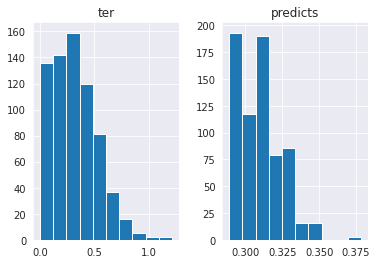

In [29]:
SVR_model = SVR()
SVR_params = { 'kernel' : ['rbf'], # Kernel type to be used in the algorithm
              'epsilon': np.arange(0.001, 0.15, 0.04), 
              'C': np.arange(5,35, 10) #  Regularization parameter (a penality)
             }
# execute search to get estimators
fitted_model = RandomizedSearchCV(SVR_model,
                                    param_distributions=SVR_params,
                                    cv=5,
                                    scoring="neg_mean_squared_error",
                                    verbose=0,
                                    return_train_score=True).fit(X_train, y_train)
                                    
best_rmse = math.sqrt(-fitted_model.best_score_)
svr_estimator = fitted_model.best_estimator_

# summarize result   
print("Best cross validated rmse score: {}".format(math.sqrt((-1)*fitted_model.best_score_)))
print('Best Hyperparameters: {}'.format(fitted_model.best_params_))

# test the model on the test data 
preds = svr_estimator.predict(X_test)
results = pd.DataFrame(data={"ter":y_test,"predicts":preds})
results.hist()

In [30]:
y_train.mean()

0.32149047

Even after tunning the SVR model, the prediction did not enhance. The outptut of the SVR model is centered also around 0.3 which is the mean of the y_train.


## Conclusion:
Trying to predict TER from only one feature is not feasible. More features are needed. 

# Part 2


There is many possible features that can be used to improve the predicting algorithms.

Here they are:


*   Similarity score between source and target sentences. 
*    Surface characteristics:
      *   Length of the target sentence(number of tokens).
      *   Average token length of source and target sentences.
      *   Features related to punctuation marks in source and target sentenc such as the percentage of punctuation marks in source sentence, difference between the number of punctuation marks between source and target, etc.
      *   Numeric tokens related features such as percentage of numeric tokens in source and target sentence.
      *   Stop words in source and target sentence.

*   Part-of-speech (POS) features:
    *   Number of verbs, nouns, pronouns in source and target sentence, etc.

*   N-grams features:
    *   Number of distinct uni-grams, bi-grams and tri-grams, etc.

We might also use features about Named Entities in source and target sentences such as Persons, Locations, Organizations, etc.


# Part 3

## Feature Engineering - Feature Extraction

Install necessary packages.

*   Spacy and its en and de latest transformers language models to take advantage of its POS tagging feature.


In [ ]:
# !pip install -U spacy

In [ ]:
# !python -m spacy download en_core_web_trf

     |████████████████████████████████| 459.7 MB 30 kB/s  eta 0:00:01     |██████▍                         | 91.3 MB 9.6 MB/s eta 0:00:39     |█████████▋                      | 138.2 MB 515 kB/s eta 0:10:24     |██████████▏                     | 146.4 MB 8.1 MB/s eta 0:00:39     |████████████▋                   | 181.2 MB 6.4 MB/s eta 0:00:44     |█████████████                   | 188.2 MB 261 kB/s eta 0:17:17     |█████████████▏                  | 188.4 MB 279 kB/s eta 0:16:12     |█████████████▍                  | 193.0 MB 5.0 MB/s eta 0:00:54     |██████████████▎                 | 205.2 MB 2.0 MB/s eta 0:02:08     |██████████████▉                 | 213.2 MB 559 kB/s eta 0:07:21     |████████████████                | 228.3 MB 7.0 MB/s eta 0:00:34     |█████████████████▉              | 256.4 MB 7.6 MB/s eta 0:00:27     |██████████████████▏             | 260.7 MB 500 kB/s eta 0:06:38     |████████████████████▎           | 291.0 MB 605 kB/s eta 0:04:39     |████████████████████████▉    

In [ ]:
# !python -m spacy download de_dep_news_trf

     |████████████████████████████████| 413.0 MB 271 kB/s eta 0:00:015  |▌                               | 5.8 MB 4.7 MB/s eta 0:01:27     |▌                               | 6.2 MB 4.7 MB/s eta 0:01:26     |██▎                             | 29.0 MB 9.3 MB/s eta 0:00:42     |██▌                             | 32.8 MB 1.6 MB/s eta 0:04:02     |██▋                             | 33.1 MB 1.6 MB/s eta 0:04:02     |███▊                            | 47.5 MB 5.7 MB/s eta 0:01:05     |█████▊                          | 73.7 MB 564 kB/s eta 0:10:02     |███████▏                        | 92.5 MB 563 kB/s eta 0:09:30     |███████▌                        | 97.4 MB 1.6 MB/s eta 0:03:12     |█████████                       | 117.1 MB 4.9 MB/s eta 0:01:01     |█████████▏                      | 117.8 MB 1.4 MB/s eta 0:03:25     |██████████▎                     | 132.5 MB 6.7 MB/s eta 0:00:42     |████████████████▉               | 216.5 MB 1.5 MB/s eta 0:02:14     |██████████████████▌             | 239.0 M

*   Sentence-transformers for using SentenceBert inorder to embed the source and target sentences.
 
 https://github.com/UKPLab/sentence-transformers


In [ ]:
# !pip install -U sentence-transformers

In [31]:
# load libraries and download necessary packages

import spacy
from nltk import ngrams
from scipy.stats import kendalltau
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

sentenceBert_model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
nlp_en = spacy.load("en_core_web_trf")
nlp_de = spacy.load("de_dep_news_trf")

nltk.download('stopwords')
from nltk.corpus import stopwords

en_stop_words = set(stopwords.words('english'))
de_stop_words = set(stopwords.words('german'))

### SentenceBert feature

Implementing the sentenceBert feature extraction.

Produce a semantically meaningful sentence embedding for both source and target sentences then compare the distance between the 2 vectors using Kendal rank correlation coefficient and cosine similarity.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html


In [32]:
def kendall_rank(a, b):
    rs = kendalltau(a, b)
    if isinstance(rs, tuple):
        return rs[0]
    return rs

def get_SentenceBertScores(s_sentence, t_sentence, model):
  """Method that takes a source and target sentence and SentenceBert model.
  It returns cosine similarity and kendall correlation between the embeddings of source and target sentences."""
  embedding = model.encode([s_sentence, t_sentence])
  s_embedding, t_embedding = embedding[0], embedding[1]
  sentenceBert_cosine_sim = cosine_similarity([s_embedding], [t_embedding])[0][0]
  sentenceBert_kendall_rank = kendall_rank(s_embedding, t_embedding)
  return sentenceBert_cosine_sim, sentenceBert_kendall_rank

  def get_scores(row, sentenceBert_model):
  s_sentence, t_sentence = row["source"], row["target"]
  row['sentenceBert_kendall_rank'] = get_SentenceBertScores(s_sentence, t_sentence, sentenceBert_model)
  row['sentenceBert_cosine_sim'], row['sentenceBert_kendall_rank'] = get_SentenceBertScores(s_sentence, t_sentence, sentenceBert_model)
  return row

### Surface features

Implementing surface features extraction.

*   percentage of punctuation marks in source and target sentence.
*   absolute difference between number of punctuation marks between source and target sentences normalised by source length.
*   absolute difference between number of punctuation marks between source and target sentences normalised by target length.
*   absolute difference between number of punctuation marks between source and target sentences.
*   average source and target token length,
*   percentage of numeric tokens in source and target sentences.
*   absolute difference between number of numeric tokens in the source and target sentence normalised by source sentence length.
*   absolute difference between number of numeric tokens in the source and target sentence.
*   length of source and target sentences.

In [33]:
def safe_division(a, b):
    return  round(a / b,  ndigits=3) if b else b

def get_surface_features(s_sentence, t_sentence, en_stop_words, de_stop_words):
  
    # initializing punctuations set  
    punc =  set(['!','(', ')', '"', '-', '[', ']', '{', '}', ';',
                 ':', '\'', '\\' , ',', '<', '>', '.', '/', '?',
                 '@', '#', '$', '%', '^', '&', '*', '_', '~'])

    s_sentence_tokens, t_sentence_tokens = s_sentence.split(" "), t_sentence.split(" ")  
    s_nb_tokens, t_nb_tokens = len(s_sentence_tokens), len(t_sentence_tokens)    # nbr of tokens in source and target sentence

    s_sum_token_length, t_sum_token_length = 0, 0
    s_nb_puncuation, t_nb_puncuation = 0, 0
    s_nb_numeric, t_nb_numeric = 0, 0
    s_nb_stop_words, t_nb_stop_words = 0, 0

    for token in s_sentence_tokens:
        s_sum_token_length += len(token)
        if token.isnumeric():
          s_nb_numeric += 1
        elif token in punc:
          s_nb_puncuation += 1

        if token in en_stop_words:
          s_nb_stop_words += 1

    for token in t_sentence_tokens:
        t_sum_token_length += len(token)
        if token.isnumeric():
          t_nb_numeric +=1
        elif token in punc:
          t_nb_puncuation +=1

        if token in de_stop_words:
          t_nb_stop_words += 1

    s_perc_puncuation = safe_division(s_nb_puncuation, s_nb_tokens)   # percentage of punctuation marks in source sentence
    t_perc_puncuation = safe_division(t_nb_puncuation, t_nb_tokens)   # percentage of punctuation marks in target sentence
    diff_s_t_nb_punc_s_normalized = safe_division(abs(s_nb_puncuation - t_nb_puncuation), s_nb_tokens)   # absolute difference between number of punctuation marks between source and target sentences normalised by source length
    diff_s_t_nb_punc_t_normalized = safe_division(abs(s_nb_puncuation - t_nb_puncuation), t_nb_tokens)   # absolute difference between number of punctuation marks between source and target sentences normalised by target length
    diff_s_t_nb_punc = abs(s_nb_puncuation - t_nb_puncuation)   # absolute difference between number of punctuation marks between source and target sentences 
    ratio_nb_punc = safe_division(s_nb_puncuation, t_nb_puncuation)

    s_avg_token_length = safe_division(s_sum_token_length, s_nb_tokens)    # average source token length
    t_avg_token_length = safe_division(t_sum_token_length, t_nb_tokens)    # average target token length

    s_perc_numeric = safe_division(s_nb_numeric, s_nb_tokens)    # percentage of numeric tokens in source sentence
    t_perc_numeric = safe_division(t_nb_numeric, t_nb_tokens)    # percentage of numeric tokens in target sentence
    diff_s_t_nb_num_s_normalized = safe_division(abs(s_nb_numeric - t_nb_numeric), s_nb_tokens)   # absolute difference between number of numeric tokens in the source and target sentence normalised by source sentence length
    diff_s_t_nb_num_t_normalized = safe_division(abs(s_nb_numeric - t_nb_numeric), t_nb_tokens)   # absolute difference between number of numeric tokens in the source and target sentence normalised by target sentence length
    diff_s_t_nb_num = abs(s_nb_numeric - t_nb_numeric)  # absolute difference between number of numeric tokens in the source and target sentence 
    ratio_nb_num = safe_division(s_nb_numeric, s_nb_numeric)

    return s_nb_tokens, t_nb_tokens, \
     s_avg_token_length, t_avg_token_length,\
     s_nb_stop_words, t_nb_stop_words, \
     s_perc_puncuation, t_perc_puncuation, \
     diff_s_t_nb_punc_s_normalized, diff_s_t_nb_punc_t_normalized, diff_s_t_nb_punc, ratio_nb_punc, \
     s_nb_numeric, t_nb_numeric, diff_s_t_nb_num, diff_s_t_nb_num_s_normalized, diff_s_t_nb_num_t_normalized, ratio_nb_num

### POS features

Implementing a some of surface features.

*   percentage of words of a particular part of speech tag (verb,  noun,  pronoun) in the source or target phrases.
*   ratio of numbers of words of a particular part of speech (verb, noun, pronoun) between the source and target phrases.


In [34]:
def get_POS_features(s_sentence, t_sentence, s_nb_tokens, t_nb_tokens, nlp_en, nlp_de):

    s_verb_count, s_noun_count, s_pronoun_count = 0, 0, 0
    t_verb_count, t_noun_count, t_pronoun_count = 0, 0, 0
        
    s_doc = nlp_en(s_sentence)
    t_doc = nlp_de(t_sentence)
        
    for token in s_doc:
        token_text = token.text
        pos_ = token.pos_
        if pos_ == "VERB":
            s_verb_count += 1
        elif pos_ == "PRON":
            s_pronoun_count += 1
        elif pos_ == "NOUN":
            s_noun_count += 1

    for token in t_doc:
        token_text = token.text
        pos_ = token.pos_
        if pos_ == "VERB":
            t_verb_count += 1
        elif pos_ == "PRON":
            t_pronoun_count += 1
        elif pos_ == "NOUN":
            t_noun_count += 1
            
    ## percentage of words of a particular part of speech tag (verb,  noun,  pronoun) in the source or target phrases
    s_perc_verb_pos = safe_division(s_verb_count, s_nb_tokens)
    s_perc_noun_pos = safe_division(s_noun_count,  s_nb_tokens)
    s_perc_pronoun_pos = safe_division(s_pronoun_count,  s_nb_tokens)  
    
    t_perc_verb_pos = safe_division(t_verb_count, t_nb_tokens)
    t_perc_noun_pos = safe_division(t_noun_count, t_nb_tokens)
    t_perc_pronoun_pos = safe_division(t_pronoun_count, t_nb_tokens)     
    
    # ratio of numbers of words of a particular part of speech (verb, noun, pronoun) between the source and target phrases.
    ratio_verb_pos = safe_division(s_verb_count,  t_verb_count)
    ratio_noun_pos = safe_division(s_noun_count, t_noun_count)
    ratio_pronoun_pos = safe_division(s_pronoun_count, t_pronoun_count)

    return s_perc_verb_pos, t_perc_verb_pos, ratio_verb_pos, \
    s_perc_noun_pos, t_perc_noun_pos, ratio_noun_pos, \
    s_perc_pronoun_pos, t_perc_pronoun_pos, ratio_pronoun_pos


### Extract all features

In [35]:
def extract_features(row, en_stop_words, de_stop_words, nlp_en, nlp_de, sentenceBert_model):
  """Method that extracts the surface, POS and sentenceBert Features."""

  s_sentence, t_sentence = row["source"], row["target"]

  row["s_nb_tokens"], row['t_nb_tokens'], \
     row['s_avg_token_length'], row['t_avg_token_length'],\
     row['s_nb_stop_words'], row['t_nb_stop_words'], \
     row['s_perc_puncuation'], row['t_perc_puncuation'], \
     row['diff_s_t_nb_punc'], row['diff_s_t_nb_punc_s_normalized'], row['diff_s_t_nb_punc_t_normalized'], row["ratio_nb_punc"],\
     row['s_nb_numeric'], row['t_nb_numeric'], row['diff_s_t_nb_num'],\
     row['diff_s_t_nb_num_s_normalized'], row['diff_s_t_nb_num_t_normalized'], row["ratio_nb_num"] = get_surface_features(s_sentence, t_sentence, en_stop_words, de_stop_words)
  

  s_nb_tokens, t_nb_tokens = row["s_nb_tokens"], row['t_nb_tokens']

  row['s_perc_verb_pos'], row['t_perc_verb_pos'], row['ratio_verb_pos'], \
    row['s_perc_noun_pos'], row['t_perc_noun_pos'], row['ratio_noun_pos'], \
    row['s_perc_pronoun_pos'], row['t_perc_pronoun_pos'], row['ratio_pronoun_pos'] = get_POS_features(s_sentence, t_sentence,s_nb_tokens, t_nb_tokens, nlp_en, nlp_de)
  
  row['sentenceBert_cosine_sim'], row['sentenceBert_kendall_rank'] = get_SentenceBertScores(s_sentence, t_sentence, sentenceBert_model)

  return row

In [36]:
# extract the features and save them in a new dataframe.
df_features = pd.DataFrame()
df_features = df.apply(lambda row: extract_features(row, en_stop_words, de_stop_words, nlp_en, nlp_de, sentenceBert_model), axis=1)

In [38]:
df_features.shape

(7000, 31)

In [39]:
df_features.head()

,source,target,reference,TER,s_nb_tokens,t_nb_tokens,s_avg_token_length,t_avg_token_length,s_nb_stop_words,t_nb_stop_words,s_perc_puncuation,t_perc_puncuation,diff_s_t_nb_punc,diff_s_t_nb_punc_s_normalized,diff_s_t_nb_punc_t_normalized,s_nb_numeric,t_nb_numeric,diff_s_t_nb_num,diff_s_t_nb_num_s_normalized,diff_s_t_nb_num_t_normalized,s_perc_verb_pos,t_perc_verb_pos,ratio_verb_pos,s_perc_noun_pos,t_perc_noun_pos,ratio_noun_pos,s_perc_pronoun_pos,t_perc_pronoun_pos,ratio_pronoun_pos,sentenceBert_cosine_sim,sentenceBert_kendall_rank
0,José Ortega y Gasset visited Husserl at Freiburg in 1934,1934 besuchte José Ortega y Gasset Husserl in Freiburg,José Ortega y Gasset besuchte Husserl in Freiburg im Jahr 1934,0.33,11,10,4.273,4.600,3,1,0.000,0.000,0.000,0.000,0,1,1,0,0.0,0.0,0.091,0.100,1.0,0.000,0.000,0.000,0.000,0.000,0.0,0.981580,0.874557
1,"however , a disappointing ninth in China meant that he dropped back to sixth in the standings","eine enttäuschende Neunte in China bedeutete jedoch , dass er in der Gesamtwertung auf den sechsten Platz zurückfiel","ein enttäuschender neunter Platz in China bedeutete jedoch , dass er in der Gesamtwertung auf den sechsten Platz zurückfiel",0.20,18,19,4.278,5.211,7,8,0.056,0.053,0.000,0.000,0,0,0,0,0.0,0.0,0.111,0.105,1.0,0.111,0.158,0.667,0.056,0.053,1.0,0.895195,0.703737
2,"in his diary , Chase wrote that the release of Mason and Slidell "" … was like gall and wormwood to me","in seinem Tagebuch , Chase schrieb , dass die Veröffentlichung von Mason und Slidell "" war wie Galle und Wermut für mich","in seinem Tagebuch schrieb Chase , dass die Freilassung von Mason and Slidell „ ... wie Galle und Wermut für mich war",0.30,23,23,3.478,4.304,10,11,0.087,0.130,0.043,0.043,1,0,0,0,0.0,0.0,0.043,0.043,1.0,0.174,0.174,1.000,0.087,0.043,2.0,0.913190,0.728305
3,Heavy arquebuses mounted on wagons were called arquebus à croc,schwere Arquebuses auf Waggons montiert wurden Arquebus à croc genannt,"schwere Arquebusen , die auf Wagen montiert waren , wurden „ Arquebus à croc "" genannt",0.47,11,11,4.818,5.545,2,1,0.000,0.000,0.000,0.000,0,0,0,0,0.0,0.0,0.182,0.182,1.0,0.273,0.273,1.000,0.000,0.000,0.0,0.862207,0.666860
4,"once North Pacific salmon die off after spawning , usually local bald eagles eat salmon carcasses almost exclusively","sobald der nordpazifische Lachs nach dem Laichen abstirbt , fressen in der Regel lokale Glatzadler fast ausschließlich Lachskörper","sobald der nordpazifische Lachs nach dem Laichen abgestorben ist , fressen die örtlichen Weißkopfseeadler fast ausschließlich Lachsschlachtkörper",0.44,19,19,5.211,5.947,3,5,0.053,0.053,0.000,0.000,0,0,0,0,0.0,0.0,0.158,0.105,1.5,0.211,0.263,0.800,0.000,0.000,0.0,0.738233,0.535087


### N-grams features

Implemmenting n-gram feature extraction.


*   percentage of distinct source unigrams seen in a corpus of the source language.
* percentage of distinct source bigrams seen in a corpus of the source language. 
* percentage of distinct source trigrams seen in a corpus of the source language.

It could be valuable to extract features related to the frequency of unigrams, bigrams and trigrams in differnt quartiles, such as the average unigram frequency of source sentence according to the source sentences corpus. 

In [40]:
def get_ngrams(x, n):
  return list(ngrams(word_tokenize(x), n))

def get_ngrams_features(sentences, n):
  """Method that extracts the ngrams features."""

  all_ngrams_frequencies = dict()
  all_sentences_ngrams_frequencies = []
  all_nb_distinct_ngrams = []

  for sentence in sentences:

    ngrams = get_ngrams(sentence, n)
    sentence_ngram_frequency = dict()

    for ng in ngrams:
      if ng in all_ngrams_frequencies:
        all_ngrams_frequencies[ng] += 1
      else:
        all_ngrams_frequencies[ng] = 1

      if ng in sentence_ngram_frequency:
        sentence_ngram_frequency[ng] += 1
      else:
        sentence_ngram_frequency[ng] = 1

    all_nb_distinct_ngrams.append(len(sentence_ngram_frequency))
    all_sentences_ngrams_frequencies.append(sentence_ngram_frequency)

  distinct_ngrams = len(all_ngrams_frequencies)
  all_perc_distinct_ngrams = [nb_distinct_ngrams/ distinct_ngrams for nb_distinct_ngrams in all_nb_distinct_ngrams]
  return all_perc_distinct_ngrams

Extract and add the N-grams features to the rest of the features

In [41]:
s_sentences = df["source"].tolist()
t_sentences = df["source"].tolist()

df_features["s_perc_unique_trigrams"] = get_ngrams_features(s_sentences, 3)
df_features["s_perc_unique_bigrams"] = get_ngrams_features(s_sentences, 2)
df_features["s_perc_unique_unigrams"] = get_ngrams_features(s_sentences, 1)

df_features["t_perc_unique_trigrams"] = get_ngrams_features(t_sentences, 3)
df_features["t_perc_unique_bigrams"] = get_ngrams_features(t_sentences, 2)
df_features["t_perc_unique_unigrams"] = get_ngrams_features(t_sentences, 1)

In [42]:
df_features.shape

(7000, 37)

In [43]:
df_features.head(1)

,source,target,reference,TER,s_nb_tokens,t_nb_tokens,s_avg_token_length,t_avg_token_length,s_nb_stop_words,t_nb_stop_words,s_perc_puncuation,t_perc_puncuation,diff_s_t_nb_punc,diff_s_t_nb_punc_s_normalized,diff_s_t_nb_punc_t_normalized,s_nb_numeric,t_nb_numeric,diff_s_t_nb_num,diff_s_t_nb_num_s_normalized,diff_s_t_nb_num_t_normalized,s_perc_verb_pos,t_perc_verb_pos,ratio_verb_pos,s_perc_noun_pos,t_perc_noun_pos,ratio_noun_pos,s_perc_pronoun_pos,t_perc_pronoun_pos,ratio_pronoun_pos,sentenceBert_cosine_sim,sentenceBert_kendall_rank,s_perc_unique_trigrams,s_perc_unique_bigrams,s_perc_unique_unigrams,t_perc_unique_trigrams,t_perc_unique_bigrams,t_perc_unique_unigrams
0,José Ortega y Gasset visited Husserl at Freiburg in 1934,1934 besuchte José Ortega y Gasset Husserl in Freiburg,José Ortega y Gasset besuchte Husserl in Freiburg im Jahr 1934,0.33,11,10,4.273,4.6,3,1,0.0,0.0,0.0,0.0,0,1,1,0,0.0,0.0,0.091,0.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98158,0.874557,0.000089,0.000119,0.000367,0.000089,0.000119,0.000367


### Save the features

In [44]:
# import pickle as pkl

# pkl.dump(df_features, open('dataset.pkl', "wb"))

## Define BaseLine Models

In [45]:
import pickle as pkl

df_features = pkl.load(open('dataset.pkl', "rb"))

In [46]:
df_features.columns

Index(['source', 'target', 'reference', 'TER', 's_nb_tokens', 't_nb_tokens',
       's_avg_token_length', 't_avg_token_length', 's_nb_stop_words',
       't_nb_stop_words', 's_perc_puncuation', 't_perc_puncuation',
       'diff_s_t_nb_punc', 'diff_s_t_nb_punc_s_normalized',
       'diff_s_t_nb_punc_t_normalized', 's_nb_numeric', 't_nb_numeric',
       'diff_s_t_nb_num', 'diff_s_t_nb_num_s_normalized',
       'diff_s_t_nb_num_t_normalized', 's_perc_verb_pos', 't_perc_verb_pos',
       'ratio_verb_pos', 's_perc_noun_pos', 't_perc_noun_pos',
       'ratio_noun_pos', 's_perc_pronoun_pos', 't_perc_pronoun_pos',
       'ratio_pronoun_pos', 'sentenceBert_cosine_sim',
       'sentenceBert_kendall_rank', 's_perc_unique_trigrams',
       's_perc_unique_bigrams', 's_perc_unique_unigrams',
       't_perc_unique_trigrams', 't_perc_unique_bigrams',
       't_perc_unique_unigrams'],
      dtype='object')

In [47]:
all_x_features = ['s_nb_tokens', 't_nb_tokens',
       's_avg_token_length', 't_avg_token_length', 's_nb_stop_words',
       't_nb_stop_words', 's_perc_puncuation', 't_perc_puncuation',
       'diff_s_t_nb_punc', 'diff_s_t_nb_punc_s_normalized',
       'diff_s_t_nb_punc_t_normalized', 's_nb_numeric', 't_nb_numeric',
       'diff_s_t_nb_num', 'diff_s_t_nb_num_s_normalized',
       'diff_s_t_nb_num_t_normalized', 's_perc_verb_pos', 't_perc_verb_pos',
       'ratio_verb_pos', 's_perc_noun_pos', 't_perc_noun_pos',
       'ratio_noun_pos', 's_perc_pronoun_pos', 't_perc_pronoun_pos',
       'ratio_pronoun_pos', 'sentenceBert_cosine_sim',
       'sentenceBert_kendall_rank', 's_perc_unique_trigrams',
       's_perc_unique_bigrams', 's_perc_unique_unigrams',
       't_perc_unique_trigrams', 't_perc_unique_bigrams',
       't_perc_unique_unigrams']

X = df_features[all_x_features].values.astype(np.float32)
y = df_features["TER"].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0,)

## BaseLine Models

In [49]:
scalers = ['standard', 'maxabs', 'minmax',  'quantile', 'yeo-johnson']

evaluations = [evaluation]
for for_ in ['f', 't']:
  for scaler in scalers:
    pipelines = get_scaled_models(models, scaler, for_)
    scores = evaluate_models(X_train, y_train, pipelines)
    type_col = [for_+'_'+scaler]
    cols = pd.MultiIndex.from_product([type_col, ['RMSE', 'MAE']])
    new_evaluation = pd.DataFrame(scores, columns=cols, index=model_names)
    evaluations.append(new_evaluation)

comparison2 = pd.concat(evaluations, axis=1)

In [51]:
comparison2

baseline_models            ... t_yeo-johnson          
                                     RMSE       MAE  ...          RMSE       MAE
SVR                        0.205468        0.161887  ...  0.203269      0.158655
XGBRegressor               0.204845        0.162927  ...  0.197726      0.154410
AdaBoostRegressor          0.211872        0.171154  ...  0.204828      0.160057
GradientBoostingRegressor  0.204913        0.162970  ...  0.198525      0.155044
DecisionTreeRegressor      0.205059        0.163064  ...  0.284698      0.220733
RandomForestRegressor      0.205031        0.162997  ...  0.200510      0.156503
ExtraTreesRegressor        0.205037        0.163045  ...  0.202273      0.157660
KNeighborsRegressor        0.225222        0.178873  ...  0.218940      0.170882
Ridge                      0.204745        0.162920  ...  0.199745      0.156328
Lasso                      0.204756        0.162939  ...  0.206330      0.162048

[10 rows x 22 columns]

Quering the Min MAE and RMSE

In [52]:
comparison2.xs("MAE", axis=1,level=1).apply(np.min, axis=1)

SVR                          0.153930
XGBRegressor                 0.154410
AdaBoostRegressor            0.158557
GradientBoostingRegressor    0.155044
DecisionTreeRegressor        0.163064
RandomForestRegressor        0.156503
ExtraTreesRegressor          0.157660
KNeighborsRegressor          0.165488
Ridge                        0.156328
Lasso                        0.162048
dtype: float64

In [53]:
comparison2.xs("RMSE", axis=1,level=1).apply(np.min, axis=1)

SVR                          0.195610
XGBRegressor                 0.196509
AdaBoostRegressor            0.203899
GradientBoostingRegressor    0.197298
DecisionTreeRegressor        0.205059
RandomForestRegressor        0.199299
ExtraTreesRegressor          0.200681
KNeighborsRegressor          0.211086
Ridge                        0.197270
Lasso                        0.204756
dtype: float64

SVR is the best so far. And we can see from the rest

Best cross validated rmse score: 0.1979075958734316
Best Hyperparameters: {'kernel': 'rbf', 'epsilon': 0.121, 'C': 41}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f785138ba90>,
      dtype=object)

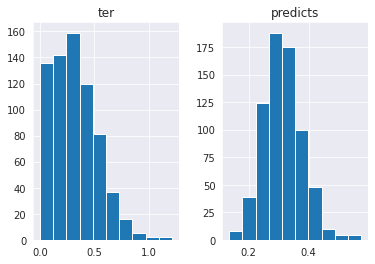

In [54]:
SVR_model = SVR()
SVR_params = { 'kernel' : ['rbf'], # Kernel type to be used in the algorithm
              'epsilon': np.arange(0.001, 0.15, 0.04), 
              'C': np.arange(5, 45, 6) #  Regularization parameter (a penality)
             }
# execute search to get estimators
fitted_model = RandomizedSearchCV(SVR_model,
                                    param_distributions=SVR_params,
                                    cv=5,
                                    scoring="neg_mean_squared_error",
                                    verbose=0,
                                    return_train_score=True).fit(X_train, y_train)
                                    
best_rmse = math.sqrt(-fitted_model.best_score_)
svr_estimator = fitted_model.best_estimator_

# summarize result   
print("Best cross validated rmse score: {}".format(math.sqrt((-1)*fitted_model.best_score_)))
print('Best Hyperparameters: {}'.format(fitted_model.best_params_))

# test the model on the test data 
preds = svr_estimator.predict(X_test)
results = pd.DataFrame(data={"ter":y_test,"predicts":preds})
results.hist()

In [ ]:
# import pickle as pkl
# pkl.dump(comparison, open("comparison2.pkl", 'wb'))

## Feature Selection

### Corrolation

We should not fit highly corrolated data in our model, otherwise we might have overfitting problem. For that reason if there are two highly corrolated features we should drop the one that has more corrolation with other feature(s).
This might be our case because we have features which are dependent on each other so for sure only one should stay but that depends on the corrolation it has with others.

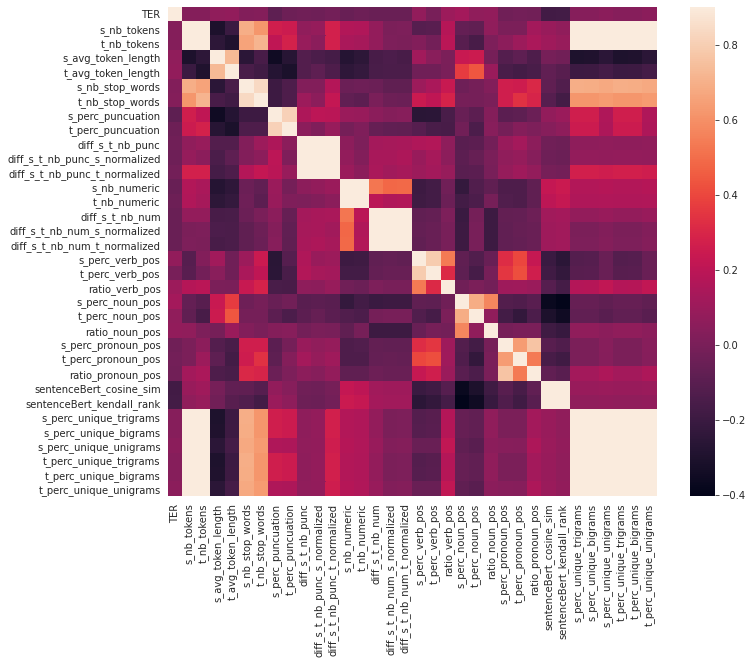

In [55]:
#Correlation map to see how features are correlated with TER
corrmat = df_features.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

As expected, features which are dependent on each other are highly corrolated. 

*  The nb of tokens for source and target sentences are highly corrolated with the n-grams features. Since n-grams are slightly more corrolated with TER we shall drop the s_nb_tokens and t_nb_tokens feature.

*  The 3 diff_numeric features has the same story. The diff_s_t_nb_num_t_normalized is slighlty more negatively corrolated with TER. so we will only keep it and drop the other 2.

* The 2 sentenceBert scores are also highly corrolated together. Both have negative corrolation with TER. sentenceBert_kendall_rank is slightly more corrolated so we are keeping it.

*   Same thing with puncuation features. We will keep diff_s_t_nb_punc_s_normalized.




In [56]:
features_drop = ['s_nb_tokens', 't_nb_tokens', 'diff_s_t_nb_num', 'diff_s_t_nb_num_t_normalized', 'sentenceBert_cosine_sim',
 'diff_s_t_nb_punc_t_normalized', 'diff_s_t_nb_punc']

df_features.drop(columns=features_drop, inplace=True)

### Feature Importance

We will use bagged decision trees like Random Forest and Extra Trees to estimate the importance of features.

In [57]:
df_features.columns

Index(['source', 'target', 'reference', 'TER', 's_avg_token_length',
       't_avg_token_length', 's_nb_stop_words', 't_nb_stop_words',
       's_perc_puncuation', 't_perc_puncuation',
       'diff_s_t_nb_punc_s_normalized', 's_nb_numeric', 't_nb_numeric',
       'diff_s_t_nb_num_s_normalized', 's_perc_verb_pos', 't_perc_verb_pos',
       'ratio_verb_pos', 's_perc_noun_pos', 't_perc_noun_pos',
       'ratio_noun_pos', 's_perc_pronoun_pos', 't_perc_pronoun_pos',
       'ratio_pronoun_pos', 'sentenceBert_kendall_rank',
       's_perc_unique_trigrams', 's_perc_unique_bigrams',
       's_perc_unique_unigrams', 't_perc_unique_trigrams',
       't_perc_unique_bigrams', 't_perc_unique_unigrams'],
      dtype='object')

In [58]:
x_features = ['s_avg_token_length',
       't_avg_token_length', 's_nb_stop_words', 't_nb_stop_words',
       's_perc_puncuation', 't_perc_puncuation',
       'diff_s_t_nb_punc_s_normalized', 's_nb_numeric', 't_nb_numeric',
       'diff_s_t_nb_num_s_normalized', 's_perc_verb_pos', 't_perc_verb_pos',
       'ratio_verb_pos', 's_perc_noun_pos', 't_perc_noun_pos',
       'ratio_noun_pos', 's_perc_pronoun_pos', 't_perc_pronoun_pos',
       'ratio_pronoun_pos', 'sentenceBert_kendall_rank',
       's_perc_unique_trigrams', 's_perc_unique_bigrams',
       's_perc_unique_unigrams', 't_perc_unique_trigrams',
       't_perc_unique_bigrams', 't_perc_unique_unigrams']

X = df_features[x_features].values.astype(np.float32)
y = df_features["TER"].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [59]:
rfg_model = RandomForestRegressor(n_estimators=1000, max_depth=3, min_samples_leaf=3, n_jobs=-1)
rfg_model.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Feature 0: s_avg_token_length, Score: 7.25298
Feature 1: t_avg_token_length, Score: 4.39069
Feature 2: s_nb_stop_words, Score: 0.61321
Feature 3: t_nb_stop_words, Score: 2.61488
Feature 4: s_perc_puncuation, Score: 10.81420
Feature 5: t_perc_puncuation, Score: 3.19267
Feature 6: diff_s_t_nb_punc_s_normalized, Score: 0.87941
Feature 7: s_nb_numeric, Score: 0.04429
Feature 8: t_nb_numeric, Score: 0.08870
Feature 9: diff_s_t_nb_num_s_normalized, Score: 0.07864
Feature 10: s_perc_verb_pos, Score: 2.46597
Feature 11: t_perc_verb_pos, Score: 0.36536
Feature 12: ratio_verb_pos, Score: 30.02712
Feature 13: s_perc_noun_pos, Score: 15.06993
Feature 14: t_perc_noun_pos, Score: 3.55898
Feature 15: ratio_noun_pos, Score: 4.98460
Feature 16: s_perc_pronoun_pos, Score: 0.40574
Feature 17: t_perc_pronoun_pos, Score: 0.42555
Feature 18: ratio_pronoun_pos, Score: 0.26519
Feature 19: sentenceBert_kendall_rank, Score: 100.00000
Feature 20: s_perc_unique_trigrams, Score: 0.93942
Feature 21: s_perc_unique_b

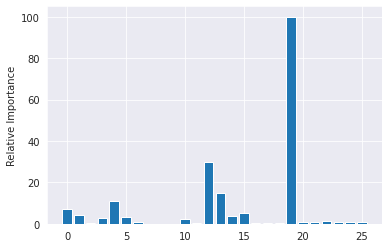

In [60]:
# get importance
importance = rfg_model.feature_importances_
# make importances relative to max importance
importance = 100.0 * (importance / importance.max())

# summarize feature importance
for i, v in enumerate(importance):
	print('Feature %0d: %s, Score: %.5f' % (i, x_features[i], v))
# plot feature importance
plt.bar(range(len(importance)), importance)
plt.ylabel('Relative Importance')
plt.show()

Now lets take the features which have importance.

In [61]:
features_imp = list(np.array(x_features)[np.array(importance)!=0])
features_imp 

['s_avg_token_length',
 't_avg_token_length',
 's_nb_stop_words',
 't_nb_stop_words',
 's_perc_puncuation',
 't_perc_puncuation',
 'diff_s_t_nb_punc_s_normalized',
 's_nb_numeric',
 't_nb_numeric',
 'diff_s_t_nb_num_s_normalized',
 's_perc_verb_pos',
 't_perc_verb_pos',
 'ratio_verb_pos',
 's_perc_noun_pos',
 't_perc_noun_pos',
 'ratio_noun_pos',
 's_perc_pronoun_pos',
 't_perc_pronoun_pos',
 'ratio_pronoun_pos',
 'sentenceBert_kendall_rank',
 's_perc_unique_trigrams',
 's_perc_unique_bigrams',
 's_perc_unique_unigrams',
 't_perc_unique_trigrams',
 't_perc_unique_bigrams',
 't_perc_unique_unigrams']

In [62]:
df_features_imp = df_features[features_imp]

In [63]:
df_features_imp.head()

,s_avg_token_length,t_avg_token_length,s_nb_stop_words,t_nb_stop_words,s_perc_puncuation,t_perc_puncuation,diff_s_t_nb_punc_s_normalized,s_nb_numeric,t_nb_numeric,diff_s_t_nb_num_s_normalized,s_perc_verb_pos,t_perc_verb_pos,ratio_verb_pos,s_perc_noun_pos,t_perc_noun_pos,ratio_noun_pos,s_perc_pronoun_pos,t_perc_pronoun_pos,ratio_pronoun_pos,sentenceBert_kendall_rank,s_perc_unique_trigrams,s_perc_unique_bigrams,s_perc_unique_unigrams,t_perc_unique_trigrams,t_perc_unique_bigrams,t_perc_unique_unigrams
0,4.273,4.600,3,1,0.000,0.000,0.000,1,1,0.0,0.091,0.100,1.0,0.000,0.000,0.000,0.000,0.000,0.0,0.874557,0.000089,0.000119,0.000367,0.000089,0.000119,0.000367
1,4.278,5.211,7,8,0.056,0.053,0.000,0,0,0.0,0.111,0.105,1.0,0.111,0.158,0.667,0.056,0.053,1.0,0.703737,0.000167,0.000211,0.000587,0.000167,0.000211,0.000587
2,3.478,4.304,10,11,0.087,0.130,0.043,0,0,0.0,0.043,0.043,1.0,0.174,0.174,1.000,0.087,0.043,2.0,0.728305,0.000223,0.000277,0.000770,0.000223,0.000277,0.000770
3,4.818,5.545,2,1,0.000,0.000,0.000,0,0,0.0,0.182,0.182,1.0,0.273,0.273,1.000,0.000,0.000,0.0,0.666860,0.000089,0.000119,0.000367,0.000089,0.000119,0.000367
4,5.211,5.947,3,5,0.053,0.053,0.000,0,0,0.0,0.158,0.105,1.5,0.211,0.263,0.800,0.000,0.000,0.0,0.535087,0.000178,0.000224,0.000623,0.000178,0.000224,0.000623


In [64]:
X = df_features_imp.values.astype(np.float32)
y = df_features["TER"].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## BaseLine models after selecting features

In [ ]:
scalers = ['standard', 'maxabs', 'minmax', 'quantile', 'yeo-johnson']

evaluations = [evaluation]
for for_ in ['f', 't']:
  for scaler in scalers:
    pipelines = get_scaled_models(models, scaler, for_)
    scores = evaluate_models(X_train, y_train, pipelines)
    type_col = [for_+ '_' +scaler]
    cols = pd.MultiIndex.from_product([type_col, ['RMSE', 'MAE']])
    new_evaluation = pd.DataFrame(scores, columns=cols, index=model_names)
    evaluations.append(new_evaluation)

comparison3 = pd.concat(evaluations, axis=1)

In [68]:
comparison3

baseline_models            ... t_yeo-johnson          
                                     RMSE       MAE  ...          RMSE       MAE
SVR                        0.205468        0.161887  ...  0.201146      0.157226
XGBRegressor               0.204845        0.162927  ...  0.197825      0.154244
AdaBoostRegressor          0.211872        0.171154  ...  0.204688      0.159311
GradientBoostingRegressor  0.204913        0.162970  ...  0.197959      0.154565
DecisionTreeRegressor      0.205059        0.163064  ...  0.281260      0.219283
RandomForestRegressor      0.205031        0.162997  ...  0.200405      0.156479
ExtraTreesRegressor        0.205037        0.163045  ...  0.201349      0.156524
KNeighborsRegressor        0.225222        0.178873  ...  0.216423      0.169597
Ridge                      0.204745        0.162920  ...  0.200520      0.156904
Lasso                      0.204756        0.162939  ...  0.206330      0.162048

[10 rows x 22 columns]

In [69]:
comparison.xs("MAE", axis=1,level=1).apply(np.min, axis=1)

SVR                          0.153930
XGBRegressor                 0.154410
AdaBoostRegressor            0.158557
GradientBoostingRegressor    0.155044
DecisionTreeRegressor        0.163064
RandomForestRegressor        0.156503
ExtraTreesRegressor          0.157660
KNeighborsRegressor          0.165488
Ridge                        0.156328
Lasso                        0.162048
dtype: float64

In [70]:
comparison3.xs("MAE", axis=1,level=1).apply(np.min, axis=1)

SVR                          0.154079
XGBRegressor                 0.154244
AdaBoostRegressor            0.159230
GradientBoostingRegressor    0.154565
DecisionTreeRegressor        0.163064
RandomForestRegressor        0.156479
ExtraTreesRegressor          0.156524
KNeighborsRegressor          0.165352
Ridge                        0.156782
Lasso                        0.162048
dtype: float64

In [71]:
comparison.xs("RMSE", axis=1,level=1).apply(np.min, axis=1)

SVR                          0.195610
XGBRegressor                 0.196509
AdaBoostRegressor            0.203899
GradientBoostingRegressor    0.197298
DecisionTreeRegressor        0.205059
RandomForestRegressor        0.199299
ExtraTreesRegressor          0.200681
KNeighborsRegressor          0.211086
Ridge                        0.197270
Lasso                        0.204756
dtype: float64

In [72]:
comparison3.xs("RMSE", axis=1,level=1).apply(np.min, axis=1)

SVR                          0.195758
XGBRegressor                 0.196818
AdaBoostRegressor            0.204019
GradientBoostingRegressor    0.197255
DecisionTreeRegressor        0.205059
RandomForestRegressor        0.199251
ExtraTreesRegressor          0.200594
KNeighborsRegressor          0.211120
Ridge                        0.197721
Lasso                        0.204756
dtype: float64

In [ ]:
# pkl.dump(comparison3, open("comparison3.pkl",'wb'))

There is a slight improvment in some models after excluding features with no importance at all.

## Fine tune

### GradientBoostingRegressor

Best cross validated rmse score: 0.19603523545639193
Best Hyperparameters: {'n_estimators': 250, 'min_samples_leaf': 140, 'max_depth': 6, 'learning_rate': 0.03, 'alpha': 0.75}
RMSE on test data:  0.1935430196945453


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f784ffff860>,
      dtype=object)

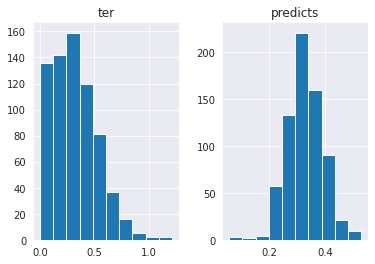

In [73]:
GBR_params = {'n_estimators' : np.arange(100, 500, 50), # Number of boosting stages to perform
              'learning_rate': np.arange(0.01, 0.1, 0.01),
              'max_depth': np.arange(2, 10, 1), # Maximum depth of the individual regression estimators
              'min_samples_leaf': np.arange(100, 200, 10), # Minimum number of samples required to be at a leaf node
              'alpha': np.arange(0.7, 0.9, 0.05)
             }

gbr_model = GradientBoostingRegressor()

# execute search to get estimators
fitted_model = RandomizedSearchCV(gbr_model,
                                    param_distributions=GBR_params,
                                    cv=5,
                                    scoring="neg_mean_squared_error",
                                    verbose=0,
                                    return_train_score=True).fit(X_train, y_train)

best_rmse = math.sqrt(-fitted_model.best_score_)
gbr_estimator = fitted_model.best_estimator_

# summarize result   
print("Best cross validated rmse score: {}".format(math.sqrt((-1)*fitted_model.best_score_)))
print('Best Hyperparameters: {}'.format(fitted_model.best_params_))

# test the model on the test data 
preds = gbr_estimator.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, preds)))
results = pd.DataFrame(data={"ter":y_test, "predicts":preds})
results.hist()

In [74]:
results.tail()

,ter,predicts
695,0.20,0.291564
696,0.29,0.217125
697,0.48,0.434356
698,0.11,0.422430
699,0.88,0.284216


### SVR

Best cross validated rmse score: 0.19793356008166602
Best Hyperparameters: {'kernel': 'rbf', 'epsilon': 0.081, 'C': 5}
RMSE on test data:  0.19757483545529453


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f784ffef358>,
      dtype=object)

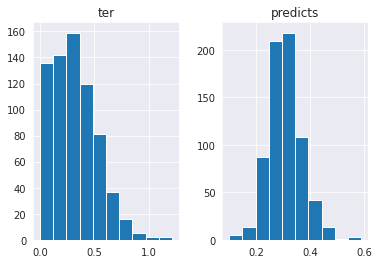

In [76]:
SVR_model = SVR()
SVR_params = { 'kernel' : ['rbf'], # Kernel type to be used in the algorithm
              'epsilon': np.arange(0.001, 0.15, 0.04), 
              'C': np.arange(5, 45, 6) #  Regularization parameter (a penality)
             }
# execute search to get estimators
fitted_model = RandomizedSearchCV(SVR_model,
                                    param_distributions=SVR_params,
                                    cv=5,
                                    scoring="neg_mean_squared_error",
                                    verbose=0,
                                    return_train_score=True).fit(X_train, y_train)
                                    
best_rmse = math.sqrt(-fitted_model.best_score_)
svr_estimator = fitted_model.best_estimator_

# summarize result   
print("Best cross validated rmse score: {}".format(best_rmse))
print('Best Hyperparameters: {}'.format(fitted_model.best_params_))

# test the model on the test data 
preds = svr_estimator.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, preds)))
results = pd.DataFrame(data={"ter":y_test,"predicts":preds})
results.hist()

### XGBRegressor

Best cross validated rmse score: 0.19683964881191618
Best Hyperparameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01}
RMSE on test data:  0.19439252671647725


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f784fe332e8>,
      dtype=object)

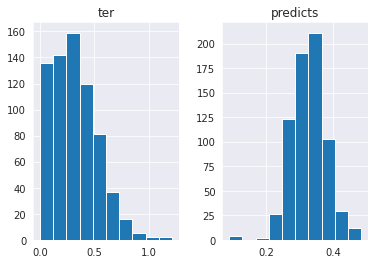

In [79]:
XGB_params = {'n_estimators' : np.arange(100, 2000, 100),
              'learning_rate': np.arange(0.01, 0.1, 0.01),
              'max_depth': np.arange(1, 10, 1) # Maximum depth of a tree
             }
xgbr_model = XGBRegressor(verbosity=0)

# execute search to get best estimator
fitted_model = RandomizedSearchCV(xgbr_model,
                                    param_distributions=XGB_params,
                                    cv=5,
                                    scoring="neg_mean_squared_error",
                                    verbose=0,
                                    return_train_score=True).fit(X_train, y_train)

best_rmse = math.sqrt(-fitted_model.best_score_)
xbgr_estimator = fitted_model.best_estimator_

# summarize result   
print("Best cross validated rmse score: {}".format(best_rmse))
print('Best Hyperparameters: {}'.format(fitted_model.best_params_))

# test the model on the test data 
preds = xbgr_estimator.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, preds)))
results = pd.DataFrame(data={"ter":y_test,"predicts":preds})
results.hist()

### RandomForestRegressor

Best cross validated rmse score: 0.19610662163712272
Best Hyperparameters: {'n_estimators': 760, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
RMSE on test data:  0.194580410629432


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f784feda550>,
      dtype=object)

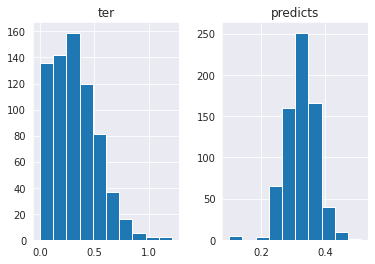

In [78]:
RFR_parms = {'n_estimators' : np.arange(10, 1000, 250), # Number of trees in random forest
              'max_features': ['sqrt', 'log2'], # Number of features to consider at every split
              'max_depth': np.append(np.arange(10, 50, 10) ,None), # Maximum number of levels in tree
              'min_samples_leaf': np.arange(1, 15, 5), # Minimum number of samples required at each leaf node
              'min_samples_split': np.arange(2, 20, 5), # Minimum number of samples required to split a node
              'bootstrap' : [True, False] # Method of selecting samples for training each tree
            }

rfr_model = RandomForestRegressor()
# execute search to get best estimator
fitted_model = RandomizedSearchCV(rfr_model,
                                    param_distributions=RFR_parms,
                                    cv=5,
                                    scoring="neg_mean_squared_error",
                                    verbose=0,
                                    return_train_score=True).fit(X_train, y_train)

best_rmse = math.sqrt((-1)*fitted_model.best_score_)
rfr_estimator = fitted_model.best_estimator_

# summarize result   
print("Best cross validated rmse score: {}".format(best_rmse))
print('Best Hyperparameters: {}'.format(fitted_model.best_params_))

# test the model on the test data 
preds = rfr_estimator.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, preds)))
results = pd.DataFrame(data={"ter":y_test,"predicts":preds})
results.hist()

In [83]:
m = RandomForestRegressor(n_estimators=760, min_samples_split=2, min_samples_leaf=6, max_features='sqrt', max_depth=10, bootstrap=True)
pipppee = Pipeline([('scaler', QuantileTransformer()), ('model', m)])
model = pipppee.fit(X_train, y_train)
# test the model on the test data 
predsss = model.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, predsss)))

RMSE on test data:  0.1945048849505882


RMSE on test data:  0.19594880717466345


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f784fc3f3c8>,
      dtype=object)

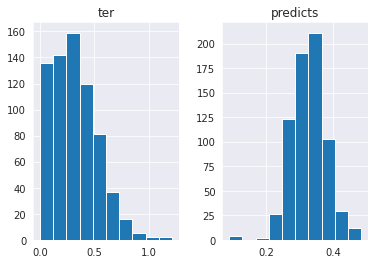

In [88]:
pipppee = Pipeline([('scaler', MaxAbsScaler()), ('model',TransformedTargetRegressor(regressor=m, transformer=PowerTransformer()))])
model = pipppee.fit(X_train, y_train)
# test the model on the test data 
predsss = model.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, predsss)))
results = pd.DataFrame(data={"ter":y_test,"predicts":preds})
results.hist()

Trying many combinations, even sometimes with very low improvment we cannot build a model to know the quality of translation with just the data at hand and the features generated.

## Balance the dataset


Its true that the results so far are a bit better that before but the models are still far from generalizing, we are facing a problem of Imbalanced data since the predictions are always near the mean of the TER. For that reason we resort to SMOGN: a Pre-processing Approach for Imbalanced Regression. It is a Python implementation of Synthetic Minority Over-Sampling Technique for Regression with Gaussian Noise. SMOGN is the more advanced algorithm for resampling the rare cases for regression problems.

*  [Smogon paper](http://proceedings.mlr.press/v74/branco17a/branco17a.pdf) 

*   [pyp package](https://pypi.org/project/smogn/)


In [ ]:
# !pip install smogn

In [ ]:
train, test = train_test_split(df_features, test_size = 0.1, random_state = 0)
df = train.reset_index(drop=True)

In [ ]:
import smogn

# use SMOGN
resampled_train = smogn.smoter(
    df,                     ## training set  (pandas dataframe)
    'TER',                      ## response variable y by name  (string)
     k = 5,                    ## num of neighs for over-sampling  (pos int)
    samp_method = "balance",   ## % over / under sample  ("balance" or extreme")
    )

In [ ]:
X_train = resampled_train[features_imp].values
y_train = resampled_train["TER"].values

X_test = test[features_imp].values
y_test = test["TER"].values

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


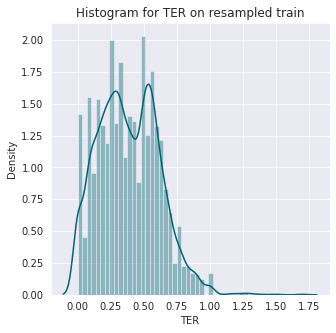

In [6]:
f, ax = plt.subplots(figsize=(5, 5))
sns.distplot(resampled_train['TER'], color="c", axlabel='TER')
ax.set(title="Histogram for TER on resampled train")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


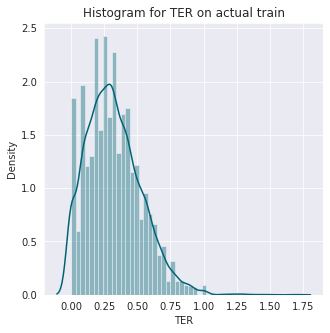

In [7]:
f, ax = plt.subplots(figsize=(5, 5))
sns.distplot(train['TER'], color="c", axlabel='TER')
ax.set(title="Histogram for TER on actual train")
plt.show()

### BaseLine

In [95]:
models , model_names = get_baseline_models()
scores = evaluate_models(X_train, y_train, models)

type_col = ['b_baseline_models']
cols = pd.MultiIndex.from_product([type_col, ['RMSE', 'MAE']])
evaluation_final = pd.DataFrame(scores, columns=cols, index=model_names)

print("Following are the cross validated scores: ")
evaluation_final

Following are the cross validated scores: 


b_baseline_models          
                                       RMSE       MAE
SVR                        0.220983          0.180919
XGBRegressor               0.210688          0.172834
AdaBoostRegressor          0.121382          0.067794
GradientBoostingRegressor  0.210462          0.172702
DecisionTreeRegressor      0.190686          0.103041
RandomForestRegressor      0.141153          0.108176
ExtraTreesRegressor        0.121107          0.069881
KNeighborsRegressor        0.219812          0.177399
Ridge                      0.223188          0.183205
Lasso                      0.231006          0.191141

We can already see better performance

### Extra Tree

Best cross validated rmse score: 0.12025780375512449
Best Hyperparameters: {'n_estimators': 600}
RMSE on test data:  0.19269561188410791


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f784e5d5be0>,
      dtype=object)

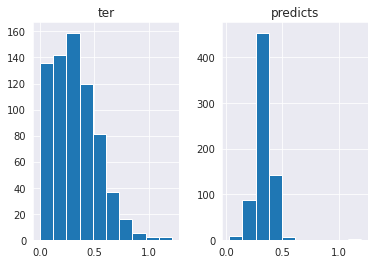

In [96]:
ExtraT_params = {'n_estimators' : np.arange(50, 1000, 50) # Number of trees in the forest
                }

etr_model = ExtraTreesRegressor()

# execute search to get best estimator
fitted_model = RandomizedSearchCV(etr_model,
                                    param_distributions=ExtraT_params,
                                    cv=5,
                                    scoring="neg_mean_squared_error",
                                    verbose=0,
                                    return_train_score=True).fit(X_train, y_train)

best_rmse = math.sqrt((-1)*fitted_model.best_score_)
etr_estimator = fitted_model.best_estimator_

# summarize result   
print("Best cross validated rmse score: {}".format(best_rmse))
print('Best Hyperparameters: {}'.format(fitted_model.best_params_))

# test the model on the test data 
preds = etr_estimator.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, preds)))
results = pd.DataFrame(data={"ter":y_test,"predicts":preds})
results.hist()

In [98]:
# Trying out with several scaling such as StandardScaler, MinMaxScaler or Power transformers, etc. MaxAbsScaler enhanced the results
pippee = Pipeline([('scaler', MaxAbsScaler()), ('model', ExtraTreesRegressor(n_estimators=600))])
model = pippee.fit(X_train, y_train)
predsss = model.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, predsss)))

RMSE on test data:  0.19206511331678358


In [99]:
pipppee = Pipeline([('scaler', MaxAbsScaler()), ('model',TransformedTargetRegressor(regressor=ExtraTreesRegressor(n_estimators=600), transformer=PowerTransformer()))])
model3 = pipppee.fit(X_train, y_train)
predsss = model3.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, predsss)))

RMSE on test data:  0.19187336423762547


In [106]:
pipppee = Pipeline([('scaler', MinMaxScaler()), ('model',TransformedTargetRegressor(regressor=ExtraTreesRegressor(n_estimators=900), transformer=PowerTransformer()))])
model3 = pipppee.fit(X_train, y_train)
predsss = model3.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, predsss)))

RMSE on test data:  0.1917593392879913


The results are getting better.

### AdaBoost

Best cross validated rmse score: 0.22126909227013872
Best Hyperparameters: {'n_estimators': 150, 'learning_rate': 0.09}
RMSE on test data:  0.21914006533506675


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f784e20f4a8>,
      dtype=object)

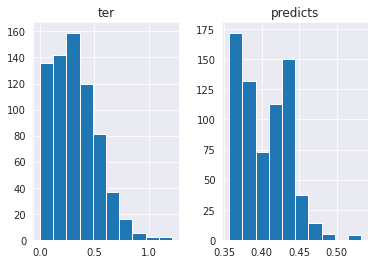

In [109]:
Ada_params = {'n_estimators' : np.arange(50,1000,50),
              'learning_rate': np.arange(0.01, 0.1, 0.01)}

adar_model = AdaBoostRegressor()

# execute search to get best estimator
fitted_model = RandomizedSearchCV(adar_model,
                                    param_distributions=Ada_params,
                                    cv=5,
                                    scoring="neg_mean_squared_error",
                                    verbose=0,
                                    return_train_score=True).fit(X_train, y_train)

best_rmse = math.sqrt((-1)*fitted_model.best_score_)
adar_estimator = fitted_model.best_estimator_

# summarize result   
print("Best cross validated rmse score: {}".format(best_rmse))
print('Best Hyperparameters: {}'.format(fitted_model.best_params_))

# test the model on the test data 
preds = adar_estimator.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, preds)))
results = pd.DataFrame(data={"ter":y_test,"predicts":preds})
results.hist()

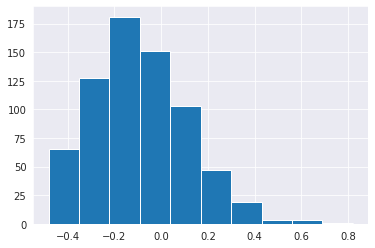

In [117]:
(results["ter"] - results["predicts"]).hist()

Tunning the hyper parameters of Random forests regressor

Best cross validated rmse score: 0.14476116100726255
Best Hyperparameters: {'n_estimators': 510, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40, 'bootstrap': False}
RMSE on test data:  0.19422122477207338


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7851225780>,
      dtype=object)

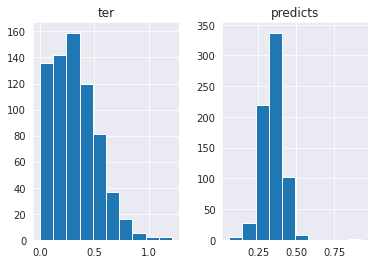

In [118]:
RFR_parms = {'n_estimators' : np.arange(10, 1000, 250), # Number of trees in random forest
              'max_features': ['sqrt', 'log2'], # Number of features to consider at every split
              'max_depth': np.append(np.arange(10, 50, 10) ,None), # Maximum number of levels in tree
              'min_samples_leaf': np.arange(1, 15, 5), # Minimum number of samples required at each leaf node
              'min_samples_split': np.arange(2, 20, 5), # Minimum number of samples required to split a node
              'bootstrap' : [True, False] # Method of selecting samples for training each tree
            }

rfr_model = RandomForestRegressor()
# execute search to get best estimator
fitted_model = RandomizedSearchCV(rfr_model,
                                    param_distributions=RFR_parms,
                                    cv=5,
                                    scoring="neg_mean_squared_error",
                                    verbose=0,
                                    return_train_score=True).fit(X_train, y_train)

best_rmse = math.sqrt((-1)*fitted_model.best_score_)
rfr_estimator = fitted_model.best_estimator_

# summarize result   
print("Best cross validated rmse score: {}".format(best_rmse))
print('Best Hyperparameters: {}'.format(fitted_model.best_params_))

# test the model on the test data 
preds = rfr_estimator.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, preds)))
results = pd.DataFrame(data={"ter":y_test,"predicts":preds})
results.hist()

In [123]:
pipppee = Pipeline([('scaler', PowerTransformer()), ('model',TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=510,
                                                                                                                   min_samples_split=12,
                                                                                                                   min_samples_leaf=1,
                                                                                                                    max_features='log2',
                                                                                                                    max_depth=40,
                                                                                                                    bootstrap=False), 
                                                                                    transformer=MinMaxScaler()))])
model3 = pipppee.fit(X_train, y_train)
predsss = model3.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, predsss)))

RMSE on test data:  0.19396443127865698


In [120]:
pipppee = Pipeline([('scaler', MaxAbsScaler()), ('model',TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=510,
                                                                                                                   min_samples_split=12,
                                                                                                                   min_samples_leaf=1,
                                                                                                                    max_features='log2',
                                                                                                                    max_depth=40,
                                                                                                                    bootstrap=False), transformer=PowerTransformer()))])
model3 = pipppee.fit(X_train, y_train)
predsss = model3.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, predsss)))

RMSE on test data:  0.19346196213728847


In [121]:
pipppee = Pipeline([('scaler', StandardScaler()), ('model',TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=510,
                                                                                                                   min_samples_split=12,
                                                                                                                   min_samples_leaf=1,
                                                                                                                    max_features='log2',
                                                                                                                    max_depth=40,
                                                                                                                    bootstrap=False), 
                                                                                    transformer=PowerTransformer()))])
model3 = pipppee.fit(X_train, y_train)
predsss = model3.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, predsss)))

RMSE on test data:  0.19362408542009196


### GredientBoosting

Best cross validated rmse score: 0.19197313895601628
Best Hyperparameters: {'n_estimators': 300, 'min_samples_leaf': 160, 'max_depth': 8, 'learning_rate': 0.09, 'alpha': 0.7}
RMSE on test data:  0.2027695677954815


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f784ffefcc0>,
      dtype=object)

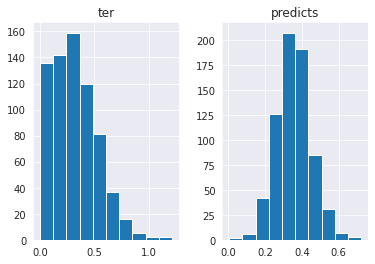

In [125]:
GBR_params = {'n_estimators' : np.arange(100, 500, 50), # Number of boosting stages to perform
              'learning_rate': np.arange(0.01, 0.1, 0.01),
              'max_depth': np.arange(2, 10, 1), # Maximum depth of the individual regression estimators
              'min_samples_leaf': np.arange(100, 200, 10), # Minimum number of samples required to be at a leaf node
              'alpha': np.arange(0.7, 0.9, 0.05)
             }

gbr_model = GradientBoostingRegressor()

# execute search to get estimators
fitted_model = RandomizedSearchCV(gbr_model,
                                    param_distributions=GBR_params,
                                    cv=5,
                                    scoring="neg_mean_squared_error",
                                    verbose=0,
                                    return_train_score=True).fit(X_train, y_train)

best_rmse = math.sqrt(-fitted_model.best_score_)
gbr_estimator = fitted_model.best_estimator_

# summarize result   
print("Best cross validated rmse score: {}".format(best_rmse))
print('Best Hyperparameters: {}'.format(fitted_model.best_params_))

# test the model on the test data 
preds = gbr_estimator.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, preds)))
results = pd.DataFrame(data={"ter":y_test,"predicts":preds})
results.hist()

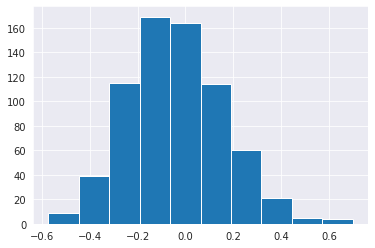

In [126]:
(results["ter"] - results["predicts"]).hist()

In [127]:
pipppee = Pipeline([('scaler', StandardScaler()), ('model',TransformedTargetRegressor(regressor=GradientBoostingRegressor(n_estimators=300,
                                                                                                                   learning_rate=0.09,
                                                                                                                   min_samples_leaf=160,
                                                                                                                    max_features='log2',
                                                                                                                    max_depth=8,
                                                                                                                    alpha=0.7), 
                                                                                    transformer=PowerTransformer()))])
model3 = pipppee.fit(X_train, y_train)
predsss = model3.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, predsss)))

RMSE on test data:  0.19857666714765618


In [128]:
pipppee = Pipeline([('scaler', MinMaxScaler()), ('model',TransformedTargetRegressor(regressor=GradientBoostingRegressor(n_estimators=300,
                                                                                                                   learning_rate=0.09,
                                                                                                                   min_samples_leaf=160,
                                                                                                                    max_features='log2',
                                                                                                                    max_depth=8,
                                                                                                                    alpha=0.7), 
                                                                                    transformer=PowerTransformer()))])
model3 = pipppee.fit(X_train, y_train)
predsss = model3.predict(X_test)
print("RMSE on test data: ", math.sqrt(metrics.mean_squared_error(y_test, predsss)))

RMSE on test data:  0.19801305956858528


Regardless of major improvment in the mean score of cross validation while performing hyperparameter finetunning with Randomized search. There is overfitting as the RMSE on the test set is much higher than that on the training set. It seems that we need more data and better distribution of the TER.
Extra Tree Regressor is the best that we achieved. Achieving 0.1202 on train data and 0.1917 RMSE on test data